In [167]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind
from scipy import stats
from matplotlib.gridspec import GridSpec
from statsmodels.stats.multicomp import pairwise_tukeyhsd

colors = np.array([(5,142,63),(4,119,59),(3,96,22),(3,68,12),(46,0,20)])/255

In [149]:
df = pd.read_csv("Data/AVRIL 25 - Complete Data.csv")

#Conversion to float
str_to_float = ["Masse sèche (g)","Epaisseur (um)","Nombre de disque","Surface (cm2)"]
for col in str_to_float:
    df[col] = df[col].str.replace(',', '.').astype(float)

# Compute SLA
df['SLA'] =  df['Surface (cm2)']/df['Masse sèche (g)']

# Sort by station
df["Station"] = ['Rhizo Bas']*16 + ['Rhizo Haut']*16 + ["Rhizo Transition"] * 12 + ["Avicennia Transition"] * 12 + ["Avicennia"] * 12



Compute statistical parameters for each station

In [150]:
df_plot = df[['Station', 'SLA']].copy()

RhBas = df_plot[df_plot['Station']=='Rhizo Bas']['SLA']
RhHaut = df_plot[df_plot['Station']=='Rhizo Haut']['SLA']
RhTransi = df_plot[df_plot['Station']=='Rhizo Transition']['SLA']
AvTransi = df_plot[df_plot['Station']=='Avicennia Transition']['SLA']
Av = df_plot[df_plot['Station']=='Avicennia']['SLA']

mean_RB, std_RhB,shap_RB = RhBas.mean(), RhBas.std(),shapiro(RhBas).pvalue
mean_RH, std_RhH, shap_RH = RhHaut.mean(), RhHaut.std(),shapiro(RhHaut).pvalue
mean_RhT, std_RhT, shap_RhT = RhTransi.mean(), RhTransi.std(),shapiro(RhTransi).pvalue
mean_AvT, std_AvT, shap_AvT = AvTransi.mean(), AvTransi.std(),shapiro(AvTransi).pvalue
mean_Avi, std_Avi, shap_Avi = Av.mean(), Av.std(),shapiro(Av).pvalue




Plot each distribution

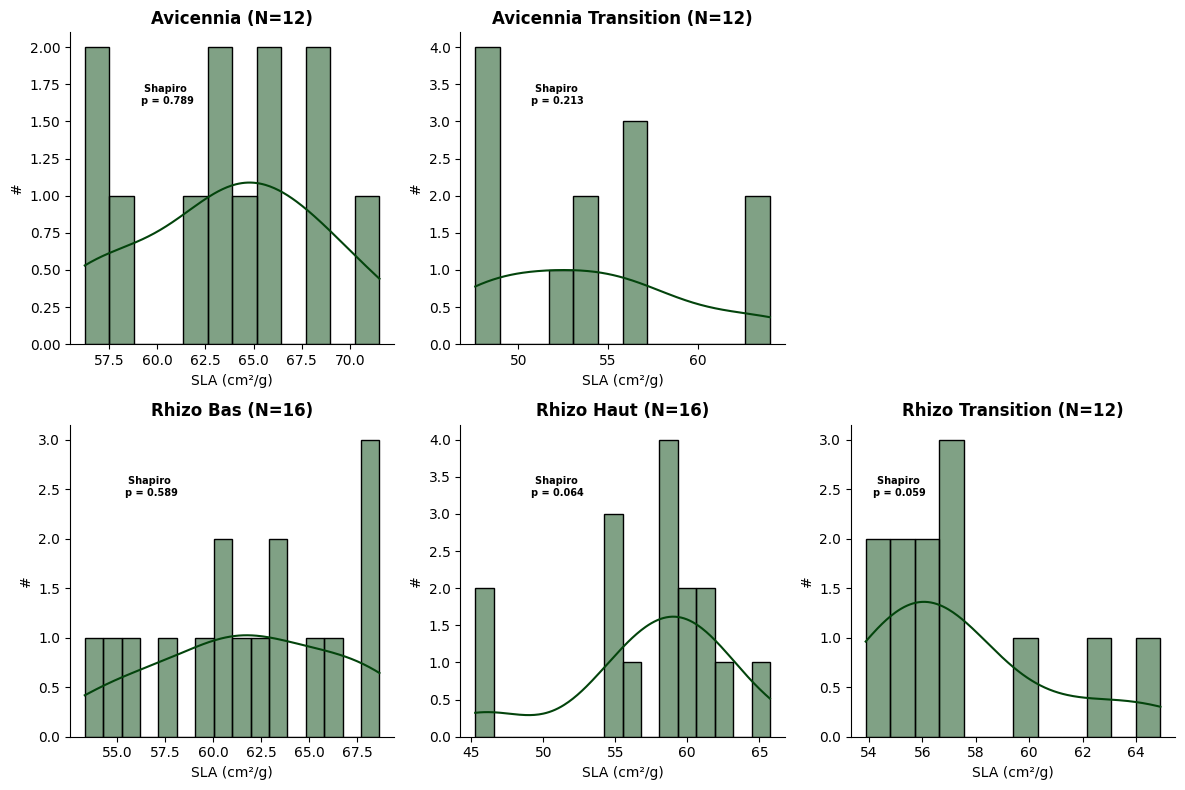

In [151]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

sns.histplot(df_plot[df_plot["Station"] == "Avicennia"]["SLA"],ax=ax1, kde=True, bins=12, color=colors[3])
sns.histplot(df_plot[df_plot["Station"] == "Avicennia Transition"]["SLA"],ax=ax2, kde=True, bins=12, color=colors[3])
sns.histplot(df_plot[df_plot["Station"] == "Rhizo Bas"]["SLA"],ax=ax3, kde=True, bins=16, color=colors[3])
sns.histplot(df_plot[df_plot["Station"] == "Rhizo Haut"]["SLA"],ax=ax4, kde=True, bins=16, color=colors[3])
sns.histplot(df_plot[df_plot["Station"] == "Rhizo Transition"]["SLA"],ax=ax5, kde=True, bins=12, color=colors[3])



ax1.set_xlabel("SLA (cm²/g)")
ax1.set_ylabel("#")
ax1.text(0.3, 0.8, f"Shapiro \np = {shap_Avi:.3f}",ha='center', va='center', transform=ax1.transAxes, fontsize=7, fontweight='bold')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title("Avicennia (N=12)", fontweight='bold')

ax2.set_xlabel("SLA (cm²/g)")
ax2.set_ylabel("#")
ax2.text(0.3, 0.8, f"Shapiro \np = {shap_AvT:.3f}",ha='center', va='center', transform=ax2.transAxes, fontsize=7, fontweight='bold')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title("Avicennia Transition (N=12)", fontweight='bold')

ax3.set_xlabel("SLA (cm²/g)")
ax3.set_ylabel("#")
ax3.text(0.25, 0.8, f"Shapiro \np = {shap_RB:.3f}",ha='center', va='center', transform=ax3.transAxes, fontsize=7, fontweight='bold')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title("Rhizo Bas (N=16)", fontweight='bold')

ax4.set_xlabel("SLA (cm²/g)")
ax4.set_ylabel("#")
ax4.text(0.3, 0.8, f"Shapiro \np = {shap_RH:.3f}",ha='center', va='center', transform=ax4.transAxes, fontsize=7, fontweight='bold')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_title("Rhizo Haut (N=16)", fontweight='bold')

ax5.set_xlabel("SLA (cm²/g)")
ax5.set_ylabel("#")
ax5.text(0.15, 0.8, f"Shapiro \np = {shap_RhT:.3f}",ha='center', va='center', transform=ax5.transAxes, fontsize=7, fontweight='bold')
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_title("Rhizo Transition (N=12)", fontweight='bold')

plt.tight_layout()

plt.savefig("Plot/SLA_distribution_histograms.pdf", dpi=500, bbox_inches='tight')

Violin plots all stations

C:\Users\arthu\AppData\Local\Temp\ipykernel_8032\710618601.py:6: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(


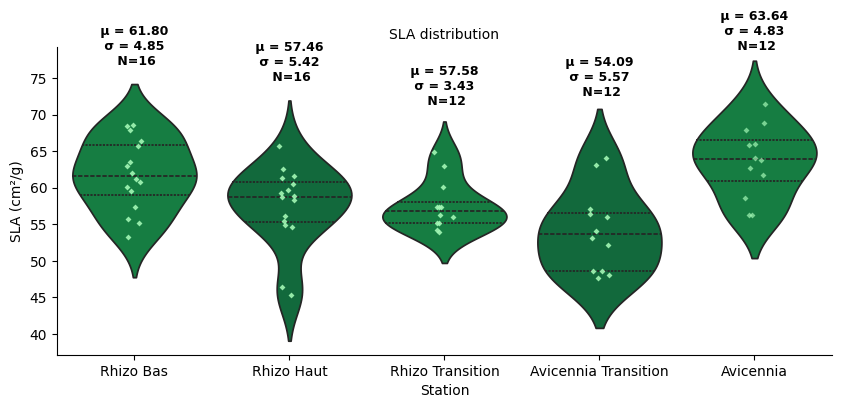

In [168]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
color_marker = (163/255,247/255,181/255)  
station_order = ['Rhizo Bas', 'Rhizo Haut', 'Rhizo Transition', 'Avicennia Transition', 'Avicennia']

sns.violinplot(
    data=df_plot,
    x='Station',
    y= 'SLA',
    hue='Station',
    ax=ax,
    inner="quart",
    palette=[colors[0], colors[1]], 
    order=station_order
)

sns.stripplot(
    data=df_plot[df_plot["Station"] == 'Avicennia'],
    x='Station',
    y='SLA',
    ax=ax,
    marker='D',
    color=color_marker,  
    size=3,
    alpha=0.7,
    jitter=0.07,
    order=station_order
)

sns.stripplot(
    data=df_plot[df_plot["Station"] == 'Avicennia Transition'],
    x='Station',
    y='SLA',
    ax=ax,
    marker='D',
    color=color_marker,  
    size=3,
    alpha=0.9,
    jitter=0.07,
    order=station_order
)

sns.stripplot(
    data=df_plot[df_plot["Station"] == 'Rhizo Transition'],
    x='Station',
    y='SLA',
    ax=ax,
    marker='D',
    color=color_marker,  
    size=3,
    alpha=0.9,
    jitter=0.07,
    order=station_order
)

sns.stripplot(
    data=df_plot[df_plot["Station"] == 'Rhizo Haut'],
    x='Station',
    y='SLA',
    ax=ax,
    marker='D',
    color=color_marker,  
    size=3,
    alpha=0.9,
    jitter=0.07,
    order=station_order
)

sns.stripplot(
    data=df_plot[df_plot["Station"] == 'Rhizo Bas'],
    x='Station',
    y='SLA',
    ax=ax,
    marker='D',
    color=color_marker,  
    size=3,
    alpha=0.9,
    jitter=0.07,
    order=station_order
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("SLA distribution", fontsize=10)
ax.set_ylabel("SLA (cm²/g)")
ax.text(0.1, 1, f" µ = {mean_RB:.2f} \n σ = {std_RhB:.2f} \n N=16",ha='center', va='center', transform=ax.transAxes, fontsize=9, fontweight='bold')
ax.text(0.3, .95, f" µ = {mean_RH:.2f} \n σ = {std_RhH:.2f} \n N=16",ha='center', va='center', transform=ax.transAxes, fontsize=9, fontweight='bold')
ax.text(0.5, .87, f" µ = {mean_RhT:.2f} \n σ = {std_RhT:.2f} \n N=12",ha='center', va='center', transform=ax.transAxes, fontsize=9, fontweight='bold')
ax.text(0.7, .9, f" µ = {mean_AvT:.2f} \n σ = {std_AvT:.2f} \n N=12",ha='center', va='center', transform=ax.transAxes, fontsize=9, fontweight='bold')
ax.text(0.9, 1.05, f" µ = {mean_Avi:.2f} \n σ = {std_Avi:.2f} \n N=12",ha='center', va='center', transform=ax.transAxes, fontsize=9, fontweight='bold');

plt.savefig("Plot/SLA_distribution_violin.pdf", dpi=500, bbox_inches='tight')

$\textbf{Statistical comparison between the \textit{Rhizophora} stations}$

ANOVA 

In [104]:
f_stat_rh, p_value_rh = stats.f_oneway(RhBas, RhHaut, RhTransi)
print(f"F-statistic: {f_stat_rh:.3f}, p-value: {p_value_rh:.6f}")

F-statistic: 4.168, p-value: 0.022499


TUKEY'S TEST

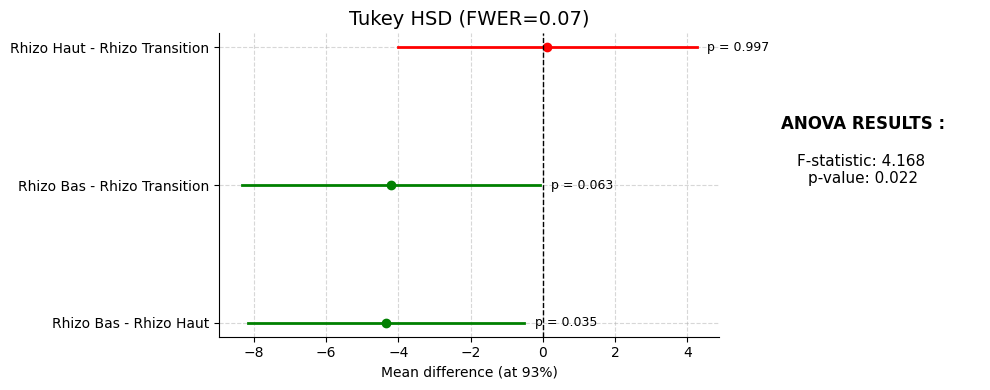

In [169]:
df_rhizo = df[df['Station'].isin(['Rhizo Bas', 'Rhizo Haut', 'Rhizo Transition'])]

tukey = pairwise_tukeyhsd(endog=df_rhizo['SLA'], groups=df_rhizo['Station'], alpha=0.07)
data = tukey.summary().data
tukey_data = pd.DataFrame({
    'group1': [ e[0] for e in data[1:]] ,
    'group2': [ e[1] for e in data[1:]],
    'meandiff': [float(e[2]) for e in data[1:]],
    'p-adj': [float(e[3]) for e in data[1:]],
    'lower': [float(e[4]) for e in data[1:]],
    'upper': [float(e[5]) for e in data[1:]],
    'reject': [e[6] for e in data[1:]],  
})

# Adding a new column for the comparison
tukey_data["comparison"] = tukey_data["group1"] + " - " + tukey_data["group2"]

# Plot
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2, width_ratios=[3, 1])  
ax_plot = fig.add_subplot(gs[0])  
ax_text = fig.add_subplot(gs[1])  

# Color mapping based on rejection
colors = tukey_data["reject"].map({True: "green", False: "red"})

# Plotting the Tukey HSD results
for i, row in tukey_data.iterrows():
    ax_plot.plot([row["lower"], row["upper"]], [i, i], color=colors[i], linewidth=2)
    ax_plot.plot(row["meandiff"], i, "o", color=colors[i], markersize=6)
    ax_plot.text(row["upper"] + 0.3, i, f"p = {row['p-adj']:.3f}", va="center", fontsize=9, color="black")

ax_plot.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax_plot.set_yticks(range(len(tukey_data)))
ax_plot.set_yticklabels(tukey_data["comparison"])
ax_plot.set_xlabel("Mean difference (at 93%)")
ax_plot.set_title("Tukey HSD (FWER=0.07)", fontsize=14)
ax_plot.spines['right'].set_visible(False)
ax_plot.spines['top'].set_visible(False)
ax_plot.grid(True, linestyle='--', alpha=0.5)

ax_text.text(0.3, 0.7, "ANOVA RESULTS :", 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=12, color="black",fontweight='bold',  transform=ax_text.transAxes)

ax_text.text(0.3, 0.55, f"F-statistic: {f_stat_rh:.3f} \np-value: {p_value_rh:.3f}",
             horizontalalignment='center', verticalalignment='center', 
             fontsize=11, color="black", transform=ax_text.transAxes)

ax_text.axis('off')


plt.tight_layout()
plt.savefig("Plot/Tukey_HSD_Rhizo.pdf", dpi=500, bbox_inches='tight')

$\textbf{Statistical comparison between the \textit{Avicennia} stations}$

T-TEST

In [132]:
t_stat_av, p_value_av = ttest_ind(Av, AvTransi, equal_var=False)
print(f"t-statistic: {t_stat_av:.3f}, p-value: {p_value_av:.5f}")

t-statistic: 4.490, p-value: 0.00019


$\textbf{Statistical comparison between all stations}$

TUCKEY'S TEST

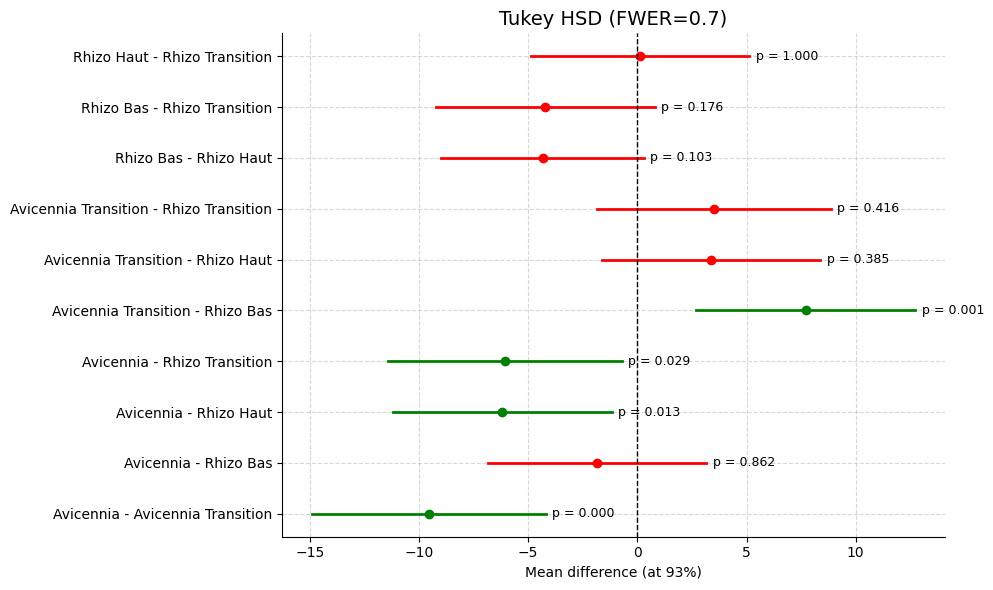

In [170]:
tukey = pairwise_tukeyhsd(endog=df_plot['SLA'], groups=df_plot['Station'], alpha=0.07)
data = tukey.summary().data

tukey_data = pd.DataFrame({
    'group1': [ e[0] for e in data[1:]] ,
    'group2': [ e[1] for e in data[1:]],
    'meandiff': [float(e[2]) for e in data[1:]],
    'p-adj': [float(e[3]) for e in data[1:]],
    'lower': [float(e[4]) for e in data[1:]],
    'upper': [float(e[5]) for e in data[1:]],
    'reject': [e[6] for e in data[1:]],  # conversion string -> bool
})

# Adding a new column for the comparison
tukey_data["comparison"] = tukey_data["group1"] + " - " + tukey_data["group2"]

#Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots(1, 1)

# Color mapping based on rejection
colors_reject = tukey_data["reject"].map({True: "green", False: "red"})


# Plotting the Tukey HSD results
for i, row in tukey_data.iterrows():
    ax.plot([row["lower"], row["upper"]], [i, i], color=colors_reject[i], linewidth=2)
    ax.plot(row["meandiff"], i, "o", color=colors_reject[i], markersize=6)
    ax.text(row["upper"] + 0.3, i, f"p = {row['p-adj']:.3f}", va="center", fontsize=9, color="black")

ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_yticks(range(len(tukey_data)), tukey_data["comparison"])
ax.set_xlabel("Mean difference (at 93%)")
ax.set_title("Tukey HSD (FWER=0.7)", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.tight_layout()
plt.savefig("Plot/Complete_Tukey_HSD.pdf", dpi=500, bbox_inches='tight')

